In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /content/drive/MyDrive/oilspill_png

In [2]:
!wget -c \
  -O /content/drive/MyDrive/oilspill_png/images.zip \
  https://zenodo.org/records/15298010/files/images.zip

--2025-12-06 16:16:05--  https://zenodo.org/records/15298010/files/images.zip
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.43.153, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148063776 (1.1G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/oilspill_png/images.zip’

/content/drive/MyDr 100%[===================>]   1.07G  56.5MB/s    in 2m 19s  

2025-12-06 16:18:25 (7.85 MB/s) - ‘/content/drive/MyDrive/oilspill_png/images.zip’ saved [1148063776/1148063776]



In [3]:
!wget -c \
  -O /content/drive/MyDrive/oilspill_png/masks.zip \
  https://zenodo.org/records/15298010/files/masks.zip

--2025-12-06 16:19:38--  https://zenodo.org/records/15298010/files/masks.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28276974 (27M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/oilspill_png/masks.zip’

/content/drive/MyDr 100%[===================>]  26.97M  4.80MB/s    in 6.1s    

2025-12-06 16:19:45 (4.41 MB/s) - ‘/content/drive/MyDrive/oilspill_png/masks.zip’ saved [28276974/28276974]



In [4]:
!unzip /content/drive/MyDrive/oilspill_png/images.zip \
  -d /content/drive/MyDrive/oilspill_png/images

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/oilspill_png/images/images/train/sentinel_555.png  
  inflating: /content/drive/MyDrive/oilspill_png/images/__MACOSX/images/train/._sentinel_555.png  
  inflating: /content/drive/MyDrive/oilspill_png/images/images/train/sentinel_2145.png  
  inflating: /content/drive/MyDrive/oilspill_png/images/__MACOSX/images/train/._sentinel_2145.png  
  inflating: /content/drive/MyDrive/oilspill_png/images/images/train/palsar_2465.png  
  inflating: /content/drive/MyDrive/oilspill_png/images/__MACOSX/images/train/._palsar_2465.png  
  inflating: /content/drive/MyDrive/oilspill_png/images/images/train/palsar_2303.png  
  inflating: /content/drive/MyDrive/oilspill_png/images/__MACOSX/images/train/._palsar_2303.png  
  inflating: /content/drive/MyDrive/oilspill_png/images/images/train/sentinel_2623.png  
  inflating: /content/drive/MyDrive/oilspill_png/images/__MACOSX/images/train/._sentinel_2623.png  
  inflating: /

In [6]:
!unzip /content/drive/MyDrive/oilspill_png/masks.zip \
  -d /content/drive/MyDrive/oilspill_png/masks


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/oilspill_png/masks/masks/train/sentinel_555.png  
  inflating: /content/drive/MyDrive/oilspill_png/masks/__MACOSX/masks/train/._sentinel_555.png  
  inflating: /content/drive/MyDrive/oilspill_png/masks/masks/train/sentinel_2145.png  
  inflating: /content/drive/MyDrive/oilspill_png/masks/__MACOSX/masks/train/._sentinel_2145.png  
  inflating: /content/drive/MyDrive/oilspill_png/masks/masks/train/palsar_2465.png  
  inflating: /content/drive/MyDrive/oilspill_png/masks/__MACOSX/masks/train/._palsar_2465.png  
  inflating: /content/drive/MyDrive/oilspill_png/masks/masks/train/palsar_2303.png  
  inflating: /content/drive/MyDrive/oilspill_png/masks/__MACOSX/masks/train/._palsar_2303.png  
  inflating: /content/drive/MyDrive/oilspill_png/masks/masks/train/sentinel_2623.png  
  inflating: /content/drive/MyDrive/oilspill_png/masks/__MACOSX/masks/train/._sentinel_2623.png  
  inflating: /content/drive/MyDriv

In [7]:
!pip install torch torchvision --quiet

In [2]:
!pip install -q segmentation-models-pytorch
!pip install -q timm

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 256

class OilSpillDataset(Dataset):
    def __init__(self, img_dir, mask_dir, augment=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.augment = augment

        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        assert len(self.images) > 0, f"No PNG images in {img_dir}"

        self.transform = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.HorizontalFlip(p=0.5 if augment else 0),
            A.VerticalFlip(p=0.5 if augment else 0),
            A.RandomRotate90(p=0.5 if augment else 0),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        filename = self.images[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, filename)).convert("RGB"))
        mask = np.array(Image.open(os.path.join(self.mask_dir, filename)).convert("L"))

        mask = (mask > 128).astype(np.float32)

        transformed = self.transform(image=img, mask=mask)
        img = transformed["image"]
        mask = transformed["mask"].unsqueeze(0)  # shape (1,H,W)

        return img, mask


# Train and Validation data load

In [4]:
BASE = "/content/drive/MyDrive/oilspill_png"

TRAIN_IMG = f"{BASE}/images/images/train"
VAL_IMG   = f"{BASE}/images/images/val"

TRAIN_MASK = f"{BASE}/masks/masks/train"
VAL_MASK   = f"{BASE}/masks/masks/val"


#Dataloaders

In [5]:
batch_size = 16

train_ds = OilSpillDataset(TRAIN_IMG, TRAIN_MASK, augment=True)
val_ds   = OilSpillDataset(VAL_IMG, VAL_MASK, augment=False)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

len(train_ds), len(val_ds)


(6455, 1615)

In [6]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

# Loss and Metrics

In [10]:
import torch
import torch.nn as nn

bce_loss = nn.BCEWithLogitsLoss()

def dice_score(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))

    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean()

def iou_score(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.mean()


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# SMP Training and Validation epochs

In [12]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, total_dice, total_iou = 0, 0, 0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)

        loss = bce_loss(logits, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_score(logits, masks).item()
        total_iou  += iou_score(logits, masks).item()

    n = len(loader)
    return total_loss/n, total_dice/n, total_iou/n


def val_one_epoch(model, loader):
    model.eval()
    total_loss, total_dice, total_iou = 0, 0, 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = bce_loss(logits, masks)

            total_loss += loss.item()
            total_dice += dice_score(logits, masks).item()
            total_iou  += iou_score(logits, masks).item()

    n = len(loader)
    return total_loss/n, total_dice/n, total_iou/n



# Training Loop

In [13]:
num_epochs = 20
best_dice = 0
save_path = "/content/drive/MyDrive/oilspill_png/unet_best.pth"

for epoch in range(num_epochs):
    tr_loss, tr_dice, tr_iou = train_one_epoch(model, train_loader)
    val_loss, val_dice, val_iou = val_one_epoch(model, val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train | Loss: {tr_loss:.4f}  Dice: {tr_dice:.4f}  IoU: {tr_iou:.4f}")
    print(f"Val   | Loss: {val_loss:.4f} Dice: {val_dice:.4f} IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), save_path)
        print("Best model saved")



Epoch 1/20
Train | Loss: 0.3266  Dice: 0.6945  IoU: 0.5756
Val   | Loss: 0.2443 Dice: 0.7756 IoU: 0.6687
Best model saved
Epoch 2/20
Train | Loss: 0.2145  Dice: 0.7571  IoU: 0.6451
Val   | Loss: 0.1822 Dice: 0.8009 IoU: 0.6974
Best model saved
Epoch 3/20
Train | Loss: 0.1914  Dice: 0.7706  IoU: 0.6616
Val   | Loss: 0.1710 Dice: 0.8068 IoU: 0.7044
Best model saved
Epoch 4/20
Train | Loss: 0.1842  Dice: 0.7766  IoU: 0.6691
Val   | Loss: 0.1907 Dice: 0.8011 IoU: 0.6985
Epoch 5/20
Train | Loss: 0.1788  Dice: 0.7823  IoU: 0.6754
Val   | Loss: 0.1704 Dice: 0.8041 IoU: 0.7053
Epoch 6/20
Train | Loss: 0.1731  Dice: 0.7822  IoU: 0.6763
Val   | Loss: 0.1727 Dice: 0.8002 IoU: 0.6996
Epoch 7/20
Train | Loss: 0.1678  Dice: 0.7882  IoU: 0.6828
Val   | Loss: 0.1602 Dice: 0.8173 IoU: 0.7196
Best model saved
Epoch 8/20
Train | Loss: 0.1666  Dice: 0.7900  IoU: 0.6852
Val   | Loss: 0.1563 Dice: 0.8229 IoU: 0.7265
Best model saved
Epoch 9/20
Train | Loss: 0.1611  Dice: 0.7951  IoU: 0.6912
Val   | Loss: 0.

# For 1-channel SAR

In [14]:
BASE = "/content/drive/MyDrive/oilspill_png"

TRAIN_IMG = f"{BASE}/images/images/train"
VAL_IMG   = f"{BASE}/images/images/val"

TRAIN_MASK = f"{BASE}/masks/masks/train"
VAL_MASK   = f"{BASE}/masks/masks/val"


In [15]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 256

class DeepSARDataset(Dataset):
    def __init__(self, img_dir, mask_dir, augment=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.augment = augment

        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        assert len(self.images) > 0, f"No PNG images found in {img_dir}"

        self.transform = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.HorizontalFlip(p=0.5 if augment else 0),
            A.VerticalFlip(p=0.5 if augment else 0),
            A.RandomRotate90(p=0.5 if augment else 0),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        filename = self.images[idx]

        img_path = os.path.join(self.img_dir, filename)
        img = np.array(Image.open(img_path).convert("L"))

        mask_path = os.path.join(self.mask_dir, filename)
        mask = np.array(Image.open(mask_path).convert("L"))

        mask = (mask > 128).astype(np.float32)

        transformed = self.transform(image=img, mask=mask)
        img = transformed["image"]              # (1, H, W)
        mask = transformed["mask"].unsqueeze(0) # (1, H, W)

        return img, mask


In [16]:
batch_size = 16

train_ds = DeepSARDataset(TRAIN_IMG, TRAIN_MASK, augment=True)
val_ds   = DeepSARDataset(VAL_IMG, VAL_MASK, augment=False)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))


Train samples: 6455
Val samples: 1615


In [17]:
import segmentation_models_pytorch as smp
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,          #
    classes=1,
    activation=None
).to(device)


In [18]:
import torch.nn as nn

bce_loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def dice_score(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))

    return ((2 * intersection + eps) / (union + eps)).mean()

def iou_score(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersection

    return ((intersection + eps) / (union + eps)).mean()


In [19]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, total_dice, total_iou = 0, 0, 0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)

        loss = bce_loss(logits, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_score(logits, masks).item()
        total_iou  += iou_score(logits, masks).item()

    n = len(loader)
    return total_loss/n, total_dice/n, total_iou/n


def val_one_epoch(model, loader):
    model.eval()
    total_loss, total_dice, total_iou = 0, 0, 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = bce_loss(logits, masks)

            total_loss += loss.item()
            total_dice += dice_score(logits, masks).item()
            total_iou  += iou_score(logits, masks).item()

    n = len(loader)
    return total_loss/n, total_dice/n, total_iou/n


In [21]:
num_epochs = 20
best_dice = 0
save_path = f"{BASE}/unet_deepsar_best.pth"

for epoch in range(num_epochs):
    tr_loss, tr_dice, tr_iou = train_one_epoch(model, train_loader)
    val_loss, val_dice, val_iou = val_one_epoch(model, val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train | Loss: {tr_loss:.4f}  Dice: {tr_dice:.4f}  IoU: {tr_iou:.4f}")
    print(f"Val   | Loss: {val_loss:.4f} Dice: {val_dice:.4f} IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), save_path)
        print("Best SAR model saved")


Epoch 1/20
Train | Loss: 0.2903  Dice: 0.6770  IoU: 0.5586
Val   | Loss: 0.2582 Dice: 0.7236 IoU: 0.6105
Best SAR model saved
Epoch 2/20
Train | Loss: 0.2330  Dice: 0.7259  IoU: 0.6108
Val   | Loss: 0.2220 Dice: 0.7596 IoU: 0.6513
Best SAR model saved
Epoch 3/20
Train | Loss: 0.2152  Dice: 0.7373  IoU: 0.6244
Val   | Loss: 0.2119 Dice: 0.7648 IoU: 0.6569
Best SAR model saved
Epoch 4/20
Train | Loss: 0.2101  Dice: 0.7465  IoU: 0.6346
Val   | Loss: 0.2080 Dice: 0.7570 IoU: 0.6500
Epoch 5/20
Train | Loss: 0.2024  Dice: 0.7533  IoU: 0.6425
Val   | Loss: 0.1934 Dice: 0.7877 IoU: 0.6828
Best SAR model saved
Epoch 6/20
Train | Loss: 0.1995  Dice: 0.7564  IoU: 0.6465
Val   | Loss: 0.1858 Dice: 0.7901 IoU: 0.6880
Best SAR model saved
Epoch 7/20
Train | Loss: 0.1892  Dice: 0.7654  IoU: 0.6563
Val   | Loss: 0.1762 Dice: 0.7924 IoU: 0.6876
Best SAR model saved
Epoch 8/20
Train | Loss: 0.1874  Dice: 0.7677  IoU: 0.6590
Val   | Loss: 0.1960 Dice: 0.7890 IoU: 0.6868
Epoch 9/20
Train | Loss: 0.1876  D

KeyboardInterrupt: 

In [20]:
## for double check purposes - before traininga
# imgs, masks = next(iter(train_loader))
# imgs = imgs.to(device)
# masks = masks.to(device)

# with torch.no_grad():
#     out = model(imgs)

# print("Input shape :", imgs.shape)
# print("Output shape:", out.shape)
# print("Dice:", dice_score(out, masks).item())
# print("IoU :", iou_score(out, masks).item())


Input shape : torch.Size([16, 1, 256, 256])
Output shape: torch.Size([16, 1, 256, 256])
Dice: 0.17132717370986938
IoU : 0.0978921502828598


# Testing

In [57]:
import torch
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
    activation=None
).to(device)

checkpoint_path = "/content/drive/MyDrive/oilspill_png/unet_deepsar_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

print("Model loaded successfully")


Model loaded successfully


Original shape : (580, 456, 3)
Grayscale shape: (580, 456)


(np.float64(-0.5), np.float64(455.5), np.float64(579.5), np.float64(-0.5))

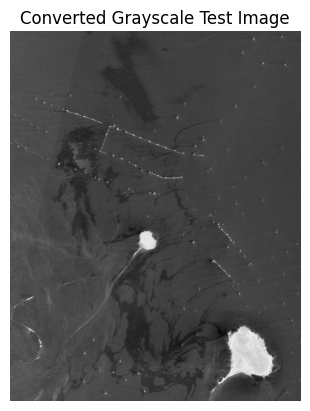

In [46]:
from PIL import Image
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

TEST_IMG_PATH = "/content/drive/MyDrive/oilspill_png/test/image_2.png"

img_rgb = Image.open(TEST_IMG_PATH).convert("RGB")
img_rgb_np = np.array(img_rgb)

img_gray = cv2.cvtColor(img_rgb_np, cv2.COLOR_RGB2GRAY)

print("Original shape :", img_rgb_np.shape)
print("Grayscale shape:", img_gray.shape)

plt.imshow(img_gray, cmap="gray")
plt.title("Converted Grayscale Test Image")
plt.axis("off")


In [47]:
img_gray_norm = img_gray.astype(np.float32) / 255.0
img_gray_norm = (img_gray_norm - 0.5) / 0.5


In [50]:
TILE_SIZE = 32

def tile_image(img, tile_size):
    h, w = img.shape
    tiles = []
    coords = []

    for y in range(0, h - tile_size + 1, tile_size):
        for x in range(0, w - tile_size + 1, tile_size):
            tile = img[y:y+tile_size, x:x+tile_size]
            tiles.append(tile)
            coords.append((y, x))

    return tiles, coords, h, w


In [51]:
tiles, coords, H, W = tile_image(img_gray_norm, TILE_SIZE)
print("Total tiles:", len(tiles))


Total tiles: 252


In [52]:
def predict_tiles(model, tiles):
    preds = []

    with torch.no_grad():
        for tile in tiles:
            tile_tensor = torch.tensor(tile).unsqueeze(0).unsqueeze(0).to(device)
            logits = model(tile_tensor)
            prob = torch.sigmoid(logits)[0,0].cpu().numpy()
            preds.append(prob)

    return preds


In [53]:
pred_tiles = predict_tiles(model, tiles)


In [54]:
full_mask = np.zeros((H, W), dtype=np.float32)

for pred, (y, x) in zip(pred_tiles, coords):
    full_mask[y:y+TILE_SIZE, x:x+TILE_SIZE] = pred


binary_mask = (full_mask > 0.5).astype(np.uint8)


In [55]:
save_path = "/content/drive/MyDrive/oilspill_png/test/predicted_oil_mask_2.png"
cv2.imwrite(save_path, binary_mask * 255)

print("Predicted full-size oil mask saved at:", save_path)


Predicted full-size oil mask saved at: /content/drive/MyDrive/oilspill_png/test/predicted_oil_mask_2.png
